In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, auc, roc_curve, confusion_matrix

from surrogate_functions import get_data_step1, print_evaluation_metrics, plot_most_important_features, plot_odds_ratio, PLTR

## Data Preparation

In [2]:
X_encoded, y, y_proba = get_data_step1()

/Users/joaosilva/Current/HEC/Interpretability Stability and Algorithmic Fairness/explainable-credit-scoring/step1/surrogate_functions.py:96: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.6876349  -1.6876349  -1.6876349  ...  0.89960459  0.89960459
  0.89960459]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_encoded.loc[:, numerical_existing] = StandardScaler().fit_transform(X_encoded[numerical_existing])
/Users/joaosilva/Current/HEC/Interpretability Stability and Algorithmic Fairness/explainable-credit-scoring/step1/surrogate_functions.py:96: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.6377609  -0.6377609  -0.6377609  ... -0.6377609  -0.6377609
  1.56798575]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_encoded.loc[:, numerical_existing] = Stand

## Logistic Regression

In [3]:
logreg = LogisticRegression(max_iter=3000, random_state=56)
logreg.fit(X_encoded, y)

LogisticRegression(max_iter=3000, random_state=56)

In [4]:
surrogate_preds_proba = logreg.predict_proba(X_encoded)[:, 1] #probs of 1
surrogate_preds = logreg.predict(X_encoded)

### Evaluating the surrogate

In [5]:
print_evaluation_metrics(y, y_proba, surrogate_preds, surrogate_preds_proba)

AUC: 0.9838573216669263
Accuracy score: 0.9904311770186222
Confusion matrix: [[876344   4921]
 [  5473 199498]]
Mean squared error: 0.29296662272848745


### Interpreting the model

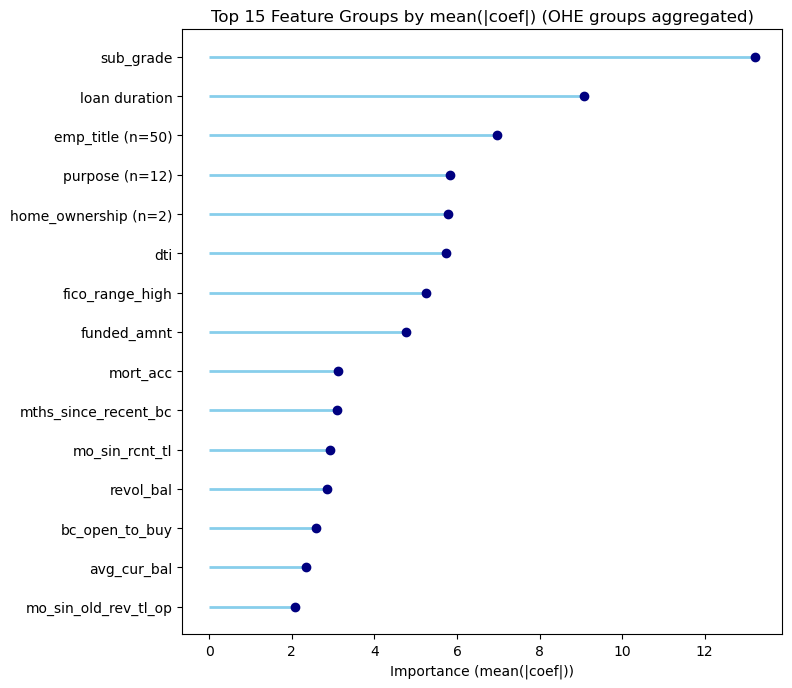

In [6]:
plot_most_important_features(logreg.coef_[0], X_encoded.columns)

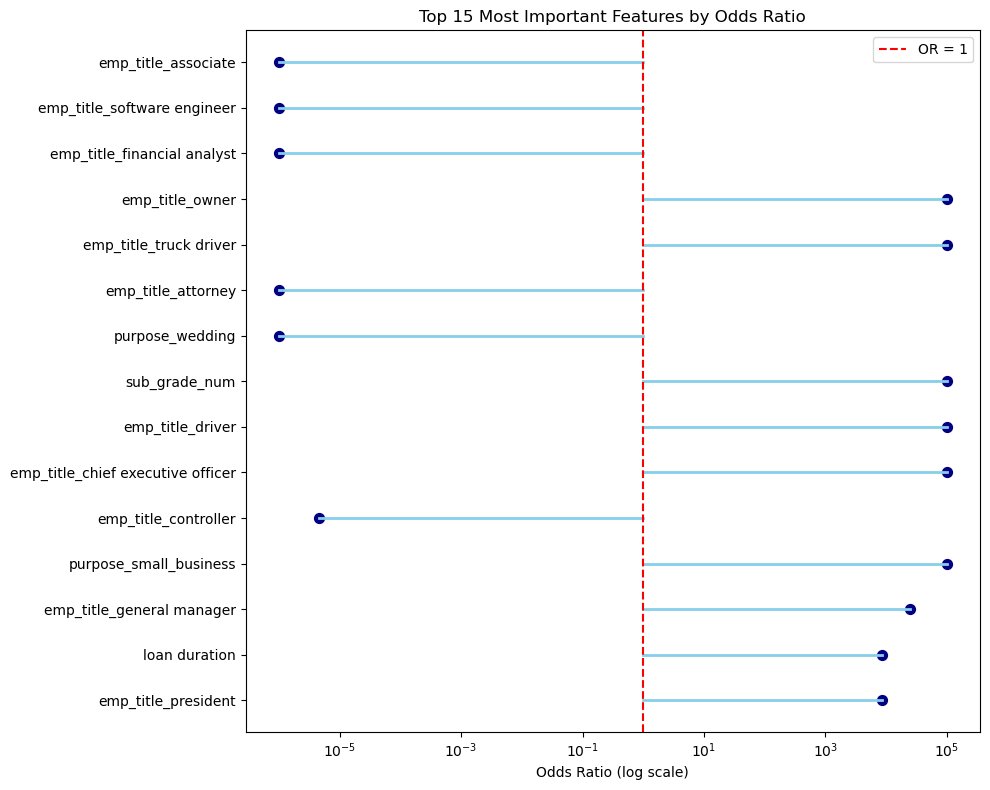

In [7]:
plot_odds_ratio(logreg.coef_[0], X_encoded.columns)

## Custom PLTR

### No Adaptive Lasso

In [8]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

pltr = PLTR(k=5, random_state=5, feature_names=X_encoded.columns)
pltr.fit(X_encoded, y, adaptive_lasso=False)

PLTR(feature_names=Index(['issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'fico_range_high',
       'funded_amnt', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl',
       'num_rev_accts', 'open_acc'...
       'emp_title_president', 'emp_title_program manager',
       'emp_title_project manager', 'emp_title_sales',
       'emp_title_sales manager', 'emp_title_server',
       'emp_title_software engineer', 'emp_title_store manager',
       'emp_title_superintendent', 'emp_title_supervisor', 'emp_title_teacher',
       'emp_title_technician', 'emp_title_truck driver',
       'emp_title_vice president'],
      dtype='object'),
     random_state=5)

In [9]:
pltr.modified_input_full

,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,fico_range_high,funded_amnt,...,emp_title_technician,emp_title_truck driver,emp_title_vice president,sub_grade_num > 0.64,sub_grade_num < 0.64xloan duration > 0.47,sub_grade_num < 0.64xsub_grade_num > 0.17,sub_grade_num < 0.64xgrade_num > 1.26,grade_num > 0.48,grade_num < 0.48xloan duration > 0.47,sub_grade_num < 0.64xsub_grade_num > 1.27
0,-1.687635,-0.637761,-0.740512,-0.745082,0.749479,-1.586997,-0.370384,-1.880644,2.106130,-1.180039,...,False,False,False,0,0,0,0,0,0,0
1,-1.687635,-0.637761,-0.470965,-0.250508,0.416937,-0.242629,-0.370384,0.530276,1.258044,1.180387,...,False,False,False,0,0,0,0,0,0,0
2,-1.687635,-0.637761,4.254853,2.390279,0.248935,0.226833,-0.370384,0.019227,1.766896,1.281169,...,False,False,False,0,0,0,0,0,0,0
3,-1.687635,-0.637761,0.841762,1.367198,-0.426078,1.147974,-0.370384,-0.633779,0.749193,-0.416216,...,False,False,False,0,0,0,0,0,0,0
4,-1.687635,1.567986,-0.155910,0.630499,-0.342077,0.497129,0.729341,0.561034,-0.946979,1.238734,...,False,False,False,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086231,0.899605,1.567986,0.316671,0.886934,0.584482,-1.654571,-0.370384,-1.190965,-0.268510,2.023775,...,False,False,False,0,1,0,0,0,1,0
1086232,0.899605,1.567986,0.439193,-0.494564,0.703429,-1.234901,2.928791,-0.797031,-0.777361,0.856823,...,False,False,False,1,0,0,0,1,0,0
1086233,0.899605,-0.637761,-0.295935,-0.603490,1.054195,-1.284692,0.729341,0.137526,1.088427,-0.628389,...,False,False,False,0,0,0,0,0,0,0
1086234,0.899605,-0.637761,-0.716007,-0.630601,-0.159313,-1.963989,0.729341,0.189577,-0.777361,-1.052735,...,False,False,False,0,0,0,0,0,0,0


In [10]:
pltr_pred = pltr.predict(pltr.modified_input_full)
pltr_pred_prob = pltr.predict_proba(pltr.modified_input_full)[:, 1]

In [11]:
print_evaluation_metrics(y, y_proba, pltr_pred, pltr_pred_prob)

AUC: 0.9878803248754557
Accuracy score: 0.9928035896435029
Confusion matrix: [[877553   3712]
 [  4105 200866]]
Mean squared error: 0.2942372087993428


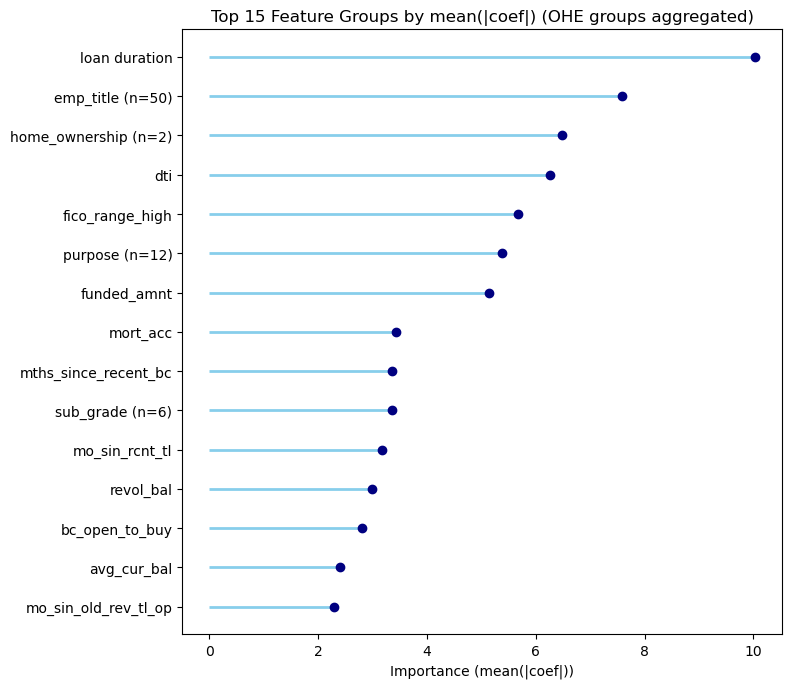

In [12]:
plot_most_important_features(pltr.pltr.coef_[0], pltr.modified_input_full.columns)

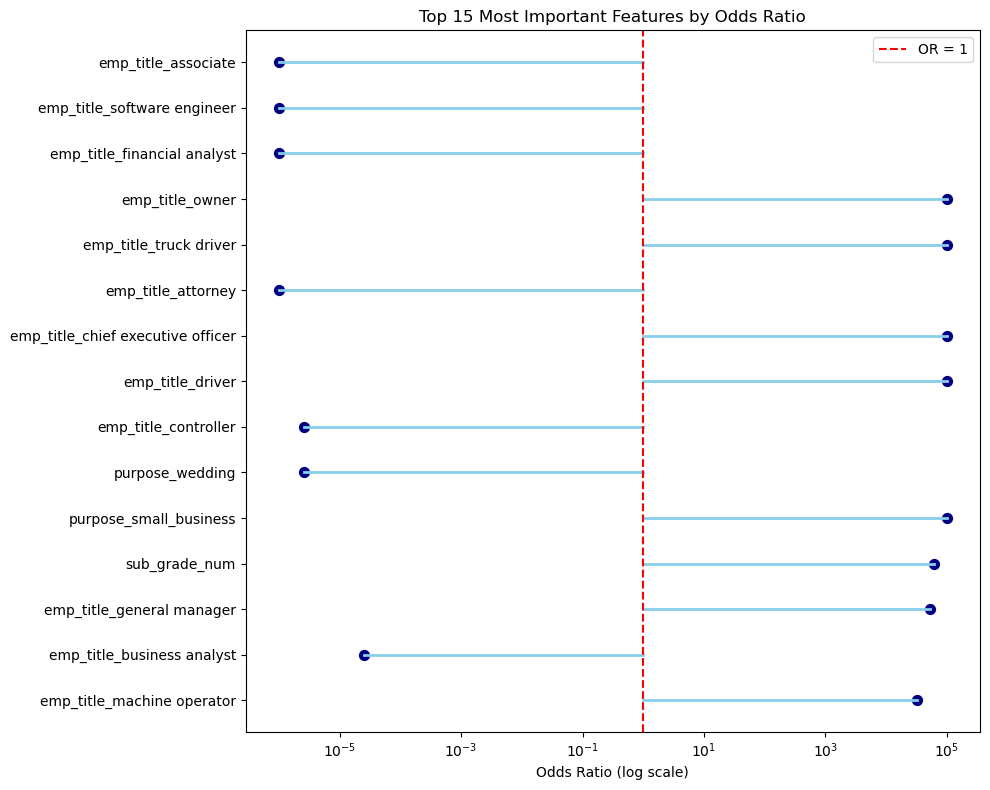

In [13]:
plot_odds_ratio(pltr.pltr.coef_[0], pltr.modified_input_full.columns)

### With Adaptive Lasso

In [14]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

pltr = PLTR(k=5, random_state=10, feature_names=X_encoded.columns)
pltr.fit(X_encoded, y, adaptive_lasso=True)

PLTR(feature_names=Index(['issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'fico_range_high',
       'funded_amnt', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl',
       'num_rev_accts', 'open_acc'...
       'emp_title_president', 'emp_title_program manager',
       'emp_title_project manager', 'emp_title_sales',
       'emp_title_sales manager', 'emp_title_server',
       'emp_title_software engineer', 'emp_title_store manager',
       'emp_title_superintendent', 'emp_title_supervisor', 'emp_title_teacher',
       'emp_title_technician', 'emp_title_truck driver',
       'emp_title_vice president'],
      dtype='object'),
     random_state=10)

In [15]:
pltr.modified_input_full

,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,fico_range_high,funded_amnt,...,emp_title_truck driver,emp_title_vice president,sub_grade_num > 0.64,sub_grade_num < 0.64xloan duration > 0.47,grade_num > 0.48,grade_num < 0.48xloan duration > 0.47,sub_grade_num < 0.64xsub_grade_num > 0.17,sub_grade_num < 0.64xsub_grade_num > 1.27,int_rate > 0.76,int_rate < 0.76xloan duration > 0.47
0,-0.061764,-6.509751,-1.284368,-1.826155,2.140680,-2.003296,-0.510301,-11.934100,12.120800,-6.134010,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,-0.061764,-6.509751,-0.816857,-0.613981,1.190865,-0.306275,-0.510301,3.365001,7.240058,6.135816,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,-0.061764,-6.509751,7.379760,5.858446,0.711014,0.286336,-0.510301,0.122012,10.168503,6.659697,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,-0.061764,-6.509751,1.459981,3.350928,-1.216975,1.449109,-0.510301,-4.021807,4.311613,-2.163549,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,-0.061764,16.004738,-0.270416,1.545320,-0.977049,0.627536,1.004859,3.560181,-5.449871,6.439115,...,0.0,0.0,5.587834,0.000000,0.239609,0.000000,0.0,0.0,0.099209,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086231,0.032923,16.004738,0.549246,2.173827,1.669411,-2.088596,-0.510301,-7.557566,-1.545277,10.519867,...,0.0,0.0,0.000000,0.166785,0.000000,0.061287,0.0,0.0,0.000000,0.109367
1086232,0.032923,16.004738,0.761751,-1.212151,2.009150,-1.558838,4.035180,-5.057762,-4.473722,4.453885,...,0.0,0.0,5.587834,0.000000,0.239609,0.000000,0.0,0.0,0.099209,0.000000
1086233,0.032923,-6.509751,-0.513279,-1.479122,3.011018,-1.621691,1.004859,0.872704,6.263910,-3.266455,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1086234,0.032923,-6.509751,-1.241867,-1.545569,-0.455033,-2.479180,1.004859,1.203009,-4.473722,-5.472267,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [16]:
pltr_pred = pltr.predict(pltr.modified_input_full)
pltr_pred_prob = pltr.predict_proba(pltr.modified_input_full)[:, 1]

In [17]:
print_evaluation_metrics(y, y_proba, pltr_pred, pltr_pred_prob)

AUC: 0.988665128333427
Accuracy score: 0.9931718337451529
Confusion matrix: [[877655   3610]
 [  3807 201164]]
Mean squared error: 0.29791717589304667


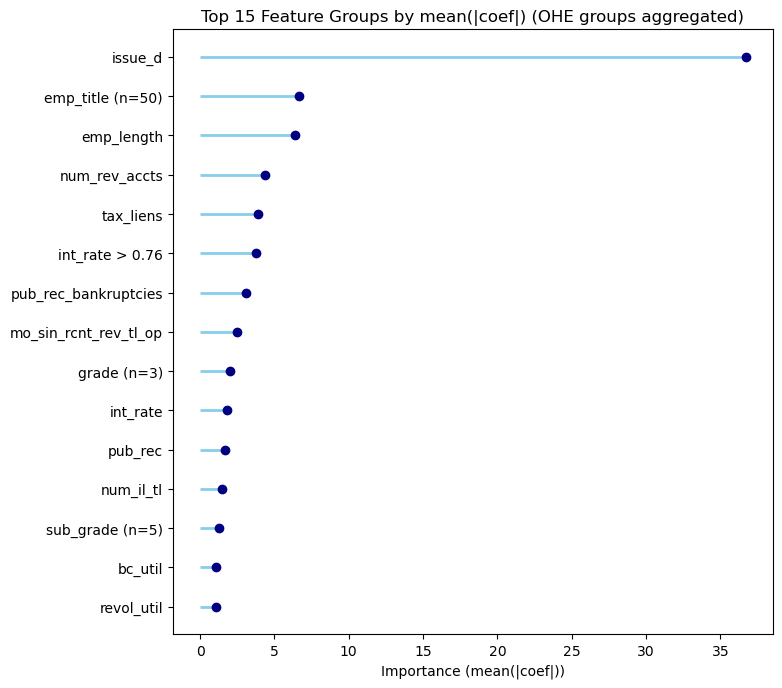

In [18]:
plot_most_important_features(pltr.pltr.coef_[0] * pltr.weights_alasso, pltr.modified_input_full.columns)

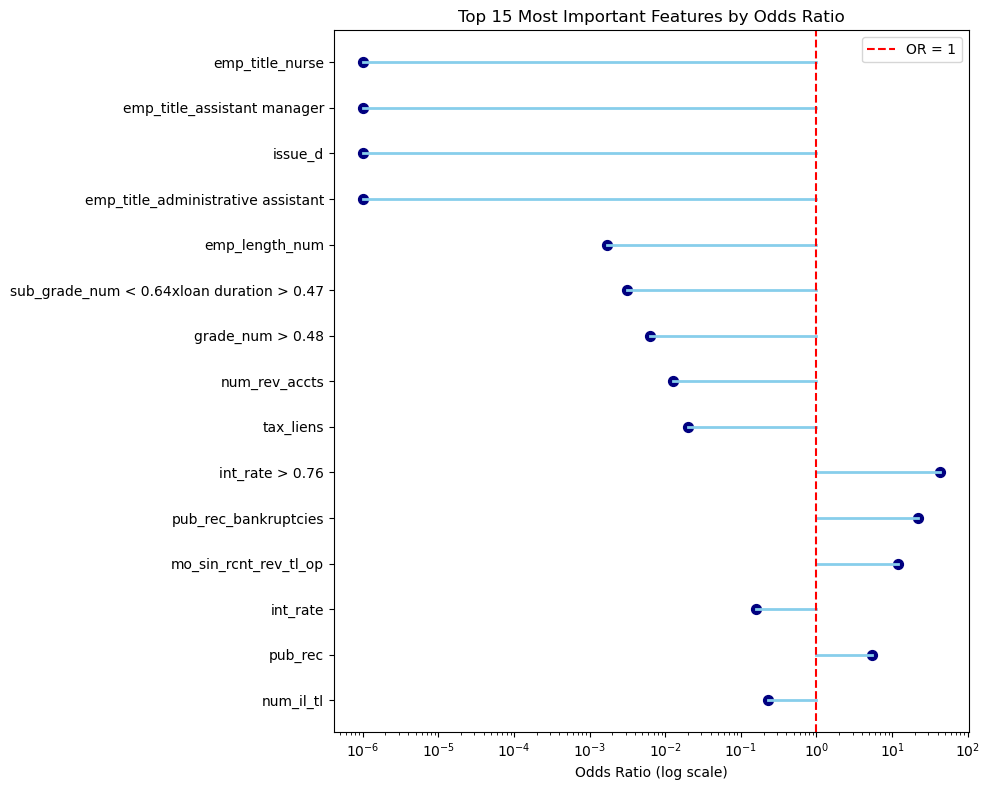

In [19]:
plot_odds_ratio(pltr.pltr.coef_[0] * pltr.weights_alasso, pltr.modified_input_full.columns)